In [63]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath('../'))

from data_loader import DataLoader
from exploratory_data_analysis import ExploratoryDataAnalysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Loading the initial data from the California housing. 



In [64]:
# Global Variables
foldername = "..\\..\\data\\raw"
foldername_to_save = "..\\..\\data\\processed"
filename = "housing.csv"

In [65]:
# Create an instance of DataLoader and load data
data_loader = DataLoader(folder_name=foldername, filename=filename)
data = data_loader.load_data()
data.head()

The original dataframe has this number of columns: 10 and rows: 20640


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Shape of the dataframe: (20640, 10) 

Columns in the dataframe: Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object') 

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


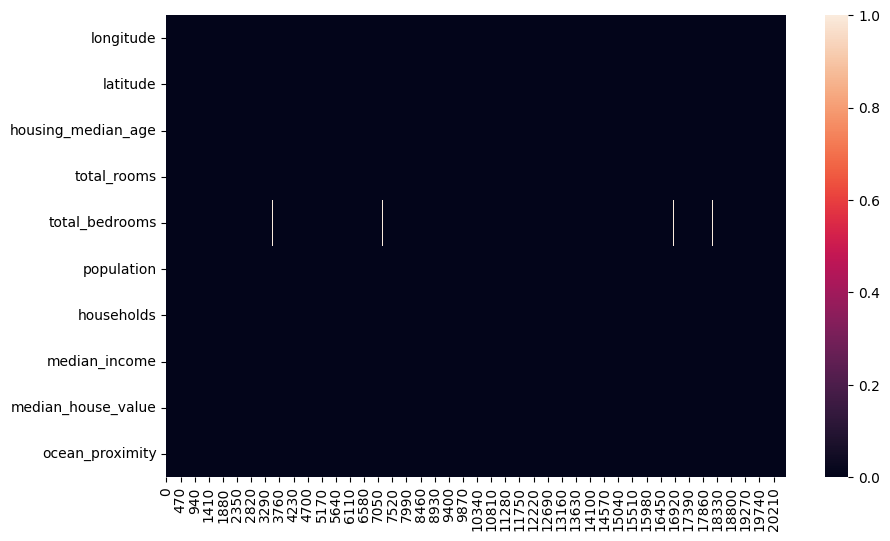

In [66]:
data_loader.initial_data_manipulatiuon(dataframe_loaded=data)
data.describe().round(2)

As observed the raw dataset has NA values in the column total_bedrooms. A total of 207 cells will need to be deal with in order to compntinue with the analysis and posterior ML model. Additionally, the max value for that column exceed greatly the mean value observed which indicates that the data is possibly skewed. 


#### Exploratory Data analysis
The number of na values corresponds to the 1% of the total data. We could implement either a forward fill or using the median value, however, for this ammount of data remove the complete rows will not impace greatly the final model. 

Shape of the dataframe: (20640, 10)
Are there duplicates in the dataframe: 0
Description of the dataframe:
        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
count   20640.00  20640.00            20640.00     20640.00        20640.00   
mean     -119.57     35.63               28.64      2635.76          536.84   
std         2.00      2.14               12.59      2181.62          419.39   
min      -124.35     32.54                1.00         2.00            1.00   
25%      -121.80     33.93               18.00      1447.75          297.00   
50%      -118.49     34.26               29.00      2127.00          435.00   
75%      -118.01     37.71               37.00      3148.00          643.25   
max      -114.31     41.95               52.00     39320.00         6445.00   

       population  households  median_income  median_house_value  
count    20640.00    20640.00       20640.00            20640.00  
mean      1425.48      499.54           3.87  

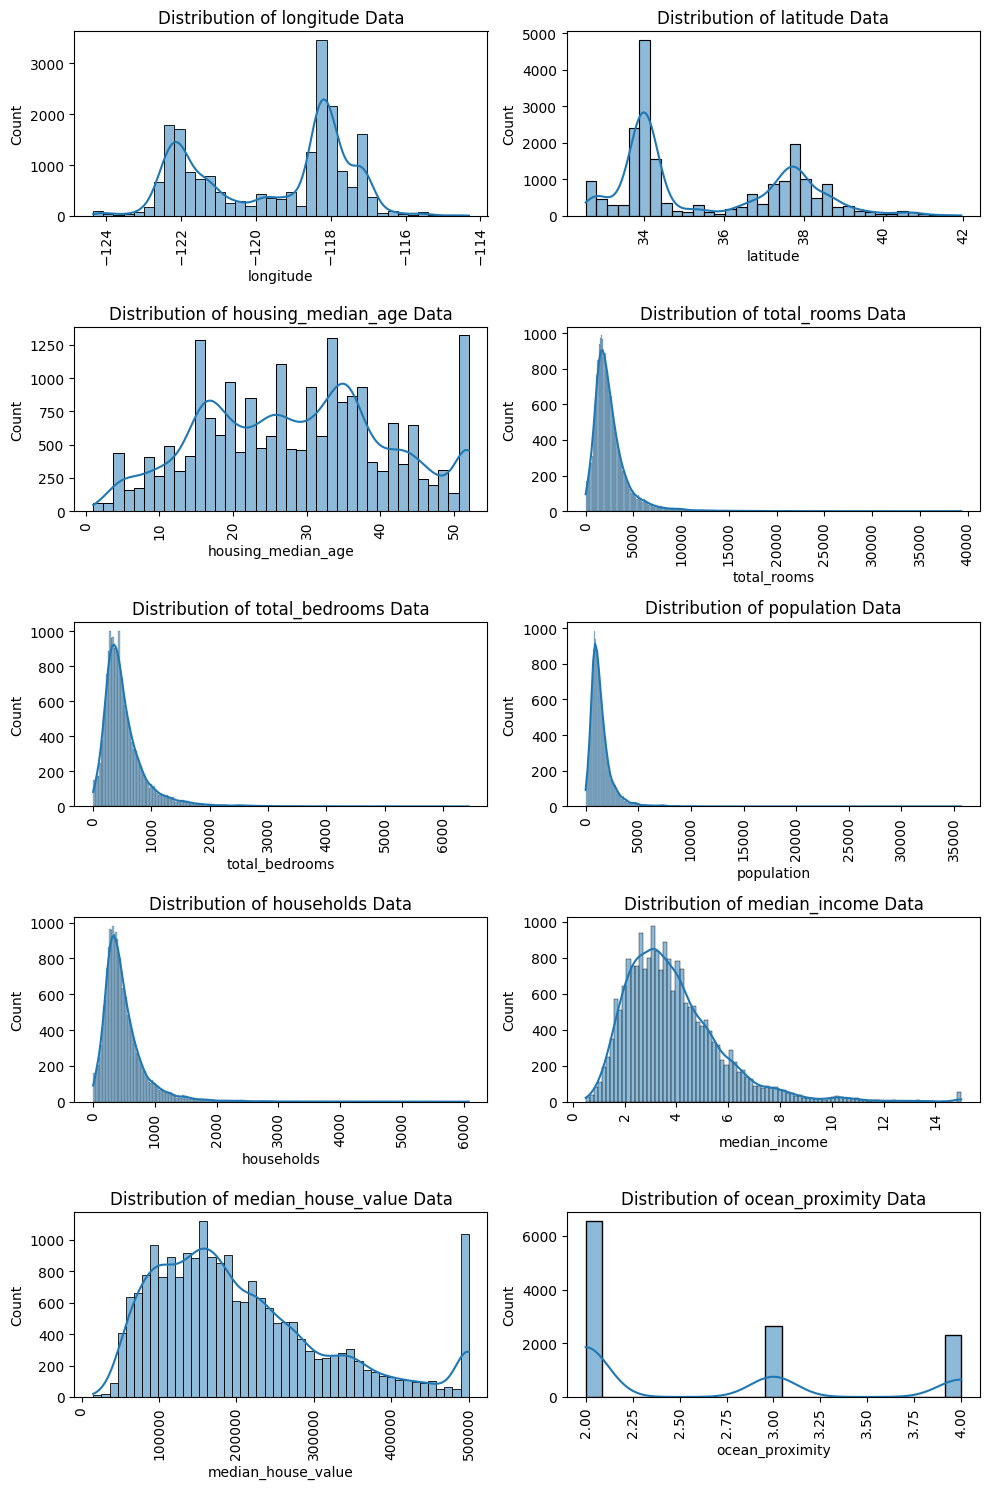

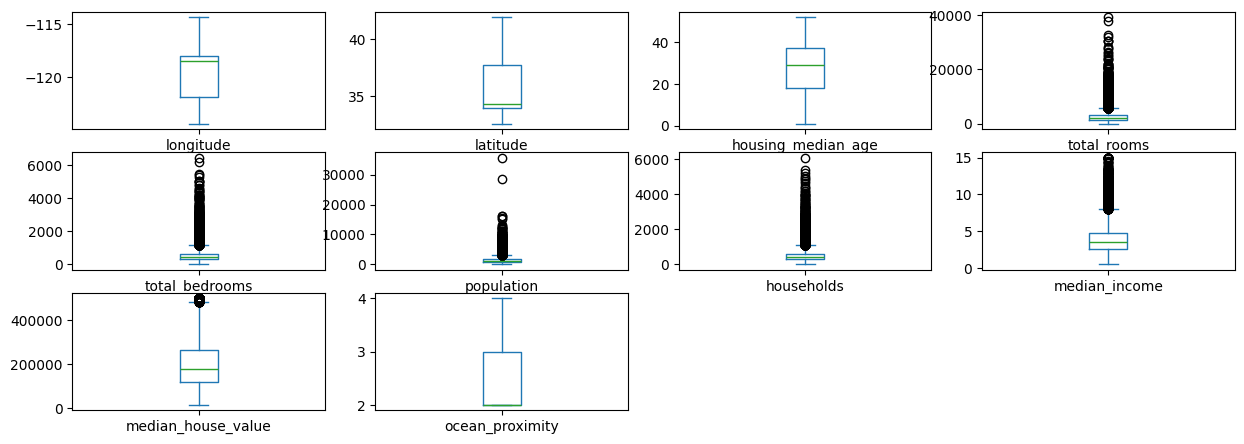

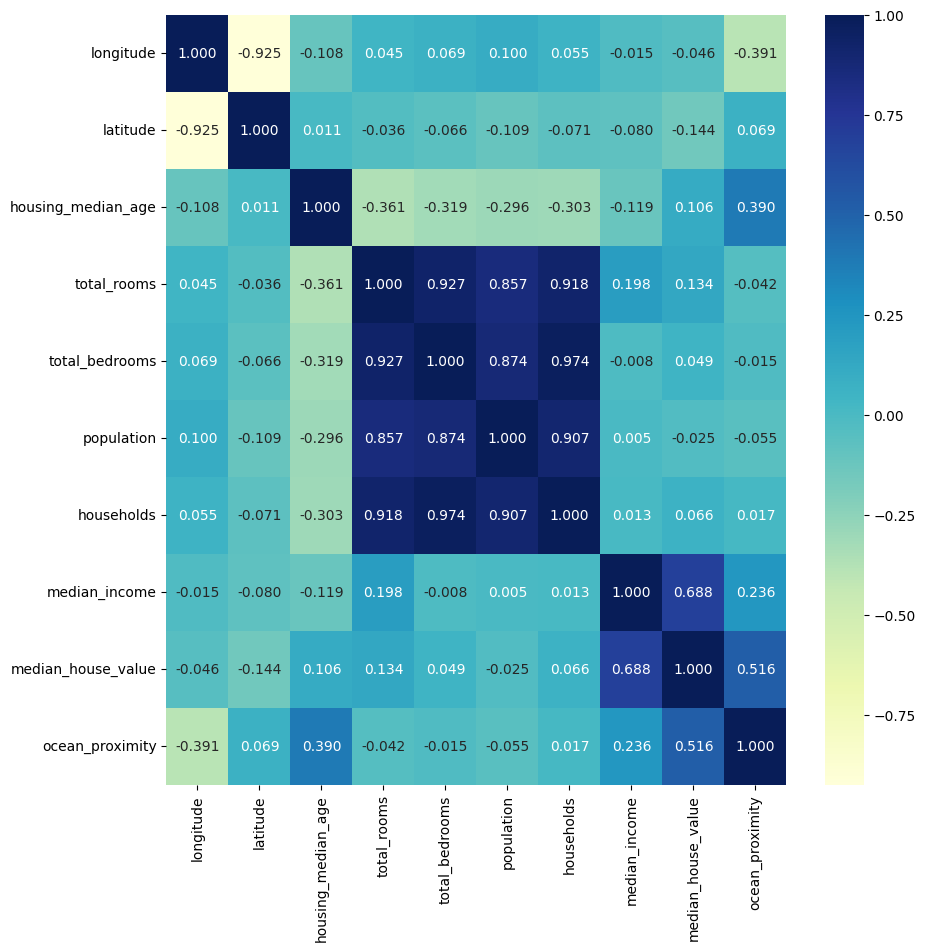

In [67]:
# This instance can take different values to deal with NA values, either drop, ffill or median
eda = ExploratoryDataAnalysis(raw_dataframe=data, na_fill_method='median', target_column="median_house_value", folder_name_to_save=foldername_to_save)
cleaned_data = eda.fill_na()
# Analyze the cleaned data
eda.analyze_data(cleaned_data)

# Converting the categorical column into numerical values using a dictionary:
cleaned_data_to_relabel = cleaned_data.copy()
cleaned_data_to_relabel["ocean_proximity"] = cleaned_data_to_relabel["ocean_proximity"].map({"1H OCEAN": 1, "INLAND" : 2, "NEAR OCEAN" : 3, "NEAR BAY" : 4})

ExploratoryDataAnalysis.visualize_data(cleaned_data_to_relabel)

It is possible to infer the folloing from the data:

    1. The target variable *(median_house_value) is skewed and most probably will need to be scaled. 
    2. There are outliers data, however, they correspond to be somewhat important, hence by keeping the data under a certain quantile can be the way to go. 
    3. There is high correlation between total of rooms and total of bedrooms, this will possibly affect the performance of the model either by multicollinearity (inflation of the variance --> overfitting) or increasing the complexity of the model without incresing the performance
    4. Calculate the ratio between the 2 variables will help better information about the data. 
    5. We could fix the skewness in the data by applying log transformation on the skewed features but we could also analyze how will the distribution will look by removing a percentage of the quantily -> e.g. keep everything lower than 90%

In [68]:
# The following instance will return the log transformed df for X and Y applied only to the columns with skewness. 
X, y, skew_df = eda.feature_engineering(cleaned_data, 'bedroom_ratio', 'total_bedrooms', 'total_rooms')
skew_df

,Feature,Skew,Abs_Skew,Skewed
0,longitude,-0.297780,0.297780,False
1,latitude,0.465919,0.465919,False
2,housing_median_age,0.060326,0.060326,False
3,total_rooms,4.147042,4.147042,True
4,total_bedrooms,3.480888,3.480888,True
5,population,4.935500,4.935500,True
6,households,3.410190,3.410190,True
7,median_income,1.646537,1.646537,True
8,bedroom_ratio,6.316445,6.316445,True


In [74]:
final_X = eda.encoder_and_scaler(X, column_to_encode='ocean_proximity')
final_X

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'bedroom_ratio'],
      dtype='object')),
                                                 ('cat', LabelEncoder(),
                                                  Index(['ocean_proximity'], dtype='object'))]))])

In [75]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,bedroom_ratio
0,-122.23,37.88,41.0,6.781058,4.867534,5.777652,4.844187,2.232720,3,0.136793
1,-122.22,37.86,21.0,8.867850,7.009409,7.784057,7.037906,2.230165,3,0.144790
2,-122.24,37.85,52.0,7.291656,5.252273,6.208590,5.181784,2.111110,3,0.121789
3,-122.25,37.85,52.0,7.150701,5.463832,6.326149,5.393628,1.893579,3,0.169286
4,-122.25,37.85,52.0,7.395108,5.638355,6.338594,5.560682,1.578195,3,0.158793
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,7.418181,5.926926,6.740519,5.802118,0.940124,1,0.202634
20636,-121.21,39.49,18.0,6.548219,5.017280,5.877736,4.744932,1.268861,1,0.194915
20637,-121.22,39.43,17.0,7.720905,6.186209,6.915723,6.073045,0.993252,1,0.194886
20638,-121.32,39.43,18.0,7.528869,6.016157,6.609349,5.857933,1.053336,1,0.198763


In [76]:
# Saving the processed data:
eda.saving_processed_data(X, y, X_name='X_data_processed', y_name='y_data_processed')

Processed data saved successfully. :)
